*************************************************
# Energy Calibration
*************************************************

In this notebook, we determine the energy of the recoils within the absorber crystal. For this procedure, we need a peak in our spectrum that originates in a calibration source, i.e. a source of recoils with known energy. From this peak, we first calculate a CPE factor, that is a linear mapping between injected test pulse amplitudes and recoil energies. In the secons step, we do a polynomail fit between measured pulse heights and injected test pulse amplitudes, to account for nonlinearities in the detector signal.

In [1]:
import cait as ai
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Rate and Stability Cuts

Before we can start with the energy calibration, we need to do several checks on our data. First, is the trigger rate stabile over the measurement time?

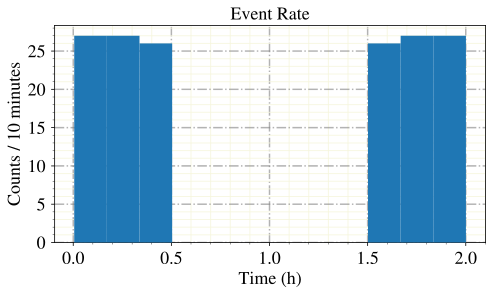

In [4]:
dh.show_values(group='events', key='hours', bins=12, 
               xlabel='Time (h)', ylabel='Counts / 10 minutes', title='Event Rate')

The gap in the histogram above is due to the fact that we use a file that was merged from two consecutive measurements (simulation, actually, in our case). Away from the gap the trigger rate is stable. The second check is, if the control pulse heights are stable.

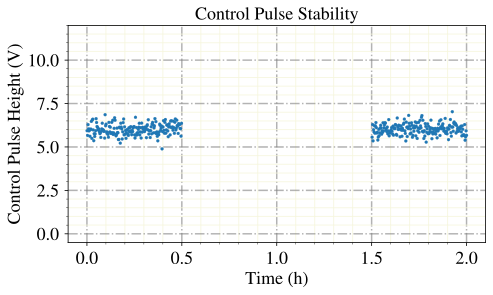

In [5]:
dh.show_scatter(groups=['controlpulses', 'controlpulses'],
                        keys=['hours', 'pulse_height'],
                        idx0s=[None, 0],
                        xlabel='Time (h)',
                        ylabel='Control Pulse Height (V)',
                        yran=(-0.5, 12),
                        title='Control Pulse Stability'
                        )

Well, they are. Other than for the control pulses in the CSMPL files (which we saw in the previous notebook), we included some variations for the control pulses in the hardware data files, to demonstrate a stability plot and cut. But first we also look at the stability of the test pulses.

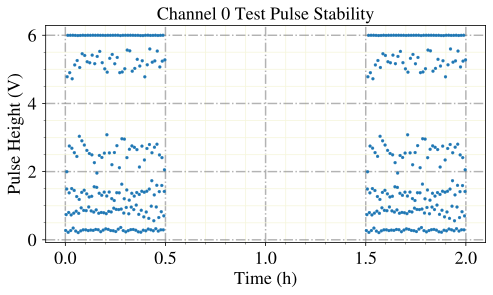

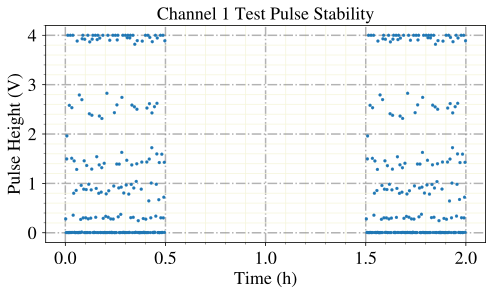

In [6]:
for c in [0,1]:
    dh.show_scatter(groups=['testpulses', 'testpulses'],
                    keys=['hours', 'mainpar'],
                    idx0s=[None, c],
                    idx2s=[None, 0],
                    xlabel='Time (h)',
                    ylabel='Pulse Height (V)',
                    marker='.',
                    title='Channel {} Test Pulse Stability'.format(c)
                    )

All stable. However, jsut for demonstration purposes, we can calculate a stability cut on the control pulses. For this we add a flag to the events group in the HDF5 file, that determines if the event is in between two stable control pulses. A control pulses is defined as stable if its height does not exceed the upper and lower bounds and does not deviate more than significance * sigma from the mean control pulse height. Here we ignore single outliers.

In [7]:
dh.calc_controlpulse_stability(channel=0, significance=3, lb=5, ub=7.5)

Do Testpulse Stability Cut
Control Pulse PH 6.019 +- 0.306, within 3 sigma: 99.500 %
Good Control Pulses: 398/400 (99.500%)
Good Events: 157/160 (98.125%)
Good Time: 0.989h/2.000h (49.458%)


The same we can do for the rate, where we flag all events as bad that are not in 10-minute intervals with a rate that does not exceed bounds and does not deviate more than sigma * significance from the average rate.

In [8]:
dh.calc_rate_cut()

Do Rate Cut.
Rate: (13.250 +- 13.255)/10m
Good Rate per 10m (3 sigma): 0.000 - 53.014
Good Time: 2.000h/2.000h (100.000%)
Good Events: 159.000/160.000 (99.375%)


We can later access these cut flags with the dh.get(group='events', dataset='controlpulse_stability') and dh.get(group='events', dataset='rate_cut') methods and include them in any cuts we want.

## Find CPE Factor

We proceed now with calculating the CPE factor, the linear mapping between injected test pulse amplitude and recoil energy. We want to do this for both our channels.

In [5]:
channels = [0, 1]

The first necessary step is to determine the position of the calibration peaks, for this we plot the spectra.

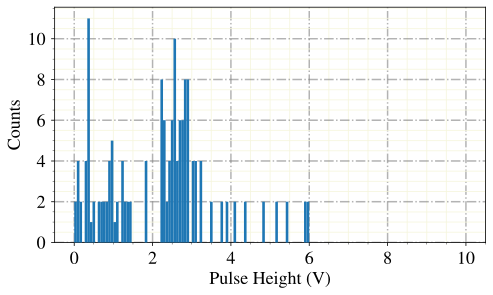

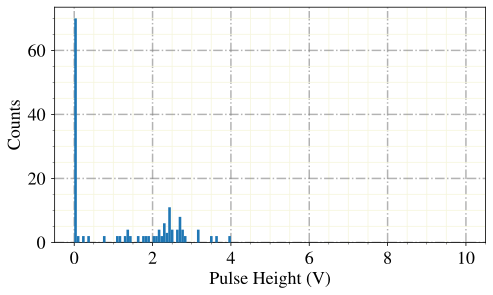

In [10]:
for c in channels:
    dh.show_values(group='events', key='mainpar', bins=150, idx0=c, idx2=0, range=(0, 10),
               xlabel='Pulse Height (V)', ylabel='Counts')

We determine their positions as the mean value within given bounds.

In [11]:
ph = dh.get('events','mainpar')[:, :, 0]
lb = [2.5, 2]
ub = [3.5, 3]
calibration_peak = []

for c in channels:
    peak_events = ai.cuts.LogicalCut(initial_condition=ph[c]>lb[c])
    peak_events.add_condition(ph[c]<ub[c])

    calibration_peak.append(np.mean(ph[c, peak_events.get_idx()]))
    print('Peak position with PH: ', calibration_peak[-1])

Peak position with PH:  2.8434481620788574
Peak position with PH:  2.4624580502510076


Second step is to determine the position of the two neighbouring test pulses, because we want to perform a linear interpolation between them. Again we determine the rough position by looking at the spectrum.

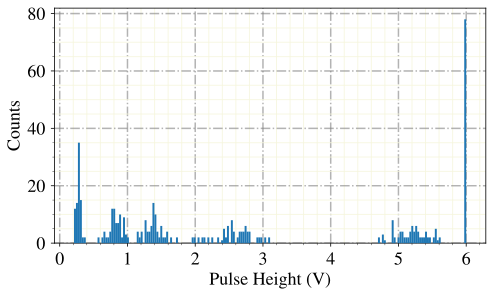

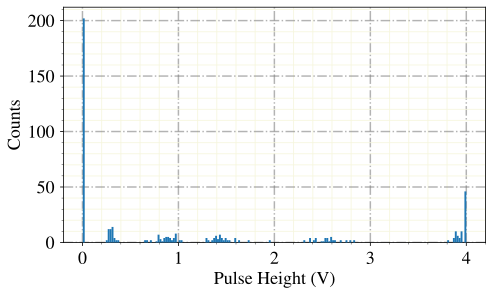

In [12]:
for c in channels:
    dh.show_values(group='testpulses', key='mainpar', bins=200, idx0=c, idx2=0,
                   xlabel='Pulse Height (V)', ylabel='Counts')

Then we determine their precise position as mean within value within given bounds.

In [13]:
ph_tp = dh.get('testpulses','mainpar')[:, :, 0]
tpas = dh.get('testpulses','testpulseamplitude')
    
tpa_peaks = []
lower_bounds = [0.6, 1.1]
upper_bounds = [1.2, 1.8]
two_tpas = [0.3, 0.5]

for c in channels:
    two_peaks = []
    for i, val in enumerate(two_tpas):
        peak_events = ai.cuts.LogicalCut(initial_condition=ph_tp[c] > lower_bounds[i])
        peak_events.add_condition(ph_tp[c] < upper_bounds[i])
        peak_events.add_condition(np.isclose(tpas, val))
        two_peaks.append(np.mean(ph_tp[c, peak_events.get_idx()]))
        print('Channel {}: Peak position TPA {} from {} events, with PH: {}'.format(c, val, len(peak_events.get_idx()), two_peaks[-1]))
    tpa_peaks.append(two_peaks)

Channel 0: Peak position TPA 0.3 from 78 events, with PH: 0.8314782318396448
Channel 0: Peak position TPA 0.5 from 80 events, with PH: 1.3893630003184079
Channel 1: Peak position TPA 0.3 from 54 events, with PH: 0.8722513597320628
Channel 1: Peak position TPA 0.5 from 50 events, with PH: 1.450446393609047


Finally, we perform a linear interpolation between the neighbouring test pulses and determine by that an equivalent TPA value for the calibration peak. The CPE factor is then just the ratio between the calibration peaks energy and equivalent TPA value.

In [14]:
energy_calibration_peak = 5.89  # iron line
cpe_factor = []

for c in channels:
    tpa_calibration_peak = two_tpas[0] + (calibration_peak[c] - tpa_peaks[c][0])*(two_tpas[1] - two_tpas[0])/(tpa_peaks[c][1] - tpa_peaks[c][0])
    print('Channel {}: The TPA corresponding to the calibration peak is {} V.'.format(c, tpa_calibration_peak))
    cpe_factor.append(energy_calibration_peak / tpa_calibration_peak)
    print('Channel {}: The CPE factor is then {} keV/V.'.format(c, cpe_factor[-1]))

Channel 0: The TPA corresponding to the calibration peak is 1.0212851269359584 V.
Channel 0: The CPE factor is then 5.767243490239668 keV/V.
Channel 1: The TPA corresponding to the calibration peak is 0.8500589238396241 V.
Channel 1: The CPE factor is then 6.928931436182691 keV/V.


This was however the easy part. The harder part is to find an equivalent TPA value for each recoil event. This is done below.

## Energy Calibration

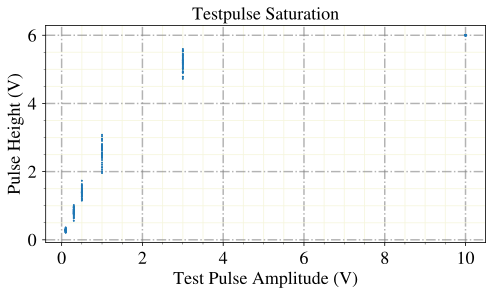

In [15]:
dh.show_saturation(show_fit=False, s=10, title='Testpulse Saturation')

To calibrate the recoil energy, we use the test pulses. We do not want to spoil the calibration by pile-up events or outliers, therefore we first calculate a stability cut on the test pulses and flag all unstable test pulses as such.

Here, we could also provide bounds for all test pulse values of all channels, to individually remove outlying pulses. As we see in above plot, this is not necessary for our data. In above plot we see, that the high energetic test pulses are saturated on top and therefore have all the very same height. This would not be the care for real measured data and it just an effect of our augmentation of saturation in the mock data.

In [16]:
for c in channels:
    dh.calc_testpulse_stability(c, significance=1, ub = None, lb = None)

Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 478/478 (100.000%)
TPA 0.100 with PH 0.279 +- 0.032, within 1 sigma: 68.750 %
TPA 0.300 with PH 0.825 +- 0.100, within 1 sigma: 67.500 %
TPA 0.500 with PH 1.389 +- 0.129, within 1 sigma: 70.000 %
TPA 1.000 with PH 2.564 +- 0.275, within 1 sigma: 70.000 %
TPA 3.000 with PH 5.193 +- 0.227, within 1 sigma: 62.500 %
TPA 10.000 with PH 5.997 +- 0.002, within 1 sigma: 76.923 %
Good Testpulses: 331/478 (69.247%)
Good Events: 102/160 (63.750%)
Good Time: 0.670h/1.998h (33.528%)
Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 349/478 (73.013%)
TPA 0.100 with PH 0.252 +- 0.115, within 1 sigma: 79.310 %
TPA 0.300 with PH 0.760 +- 0.304, within 1 sigma: 87.097 %
TPA 0.500 with PH 1.153 +- 0.591, within 1 sigma: 79.365 %
TPA 1.000 with PH 1.862 +- 1.120, wi

The precise determination of equivalent TPA values for each pulse height we do as follows:

- We use an interpolation method to determine an time continuous pulse height estimator for each individual injected test pulse amplitude. We calculate the uncertainty of the interpolation as a prediction interval.

- Then we fit a higher order polynomial at the exact time of each recoil to the Pulse Height/TPA values of the test pulses. By evaluating the polynomial at recoil time, we find an equivalent TPA value for the recoil pulse height. This we can linearly map with the CPE factor to a recoil energy. Also in this fit we include uncertainties, although the used procedure is more involved, as we have uncertainties in our independent rather than in the depending values. We can still accomplish this, by using an orthogonal distance regression, instead of an ordinary least squares regression and linear error propagation for the prediction interval.

This procedure is fully automated in below method. We have implemented as interpolation methods a gradient boosted regression tree on the 0.5 and +/- 1 sigma quantiles, and a simple linear interpolation, the second one we use here. We also need to define the start of the saturation and the order of the polynomial we want to fit.

Energy Calibration for Channel  0
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Intervals seperated by 1 h: [[0.0016666667070239782, 1.503333336552605], [1.503333336552605, 1.998333339691162]]


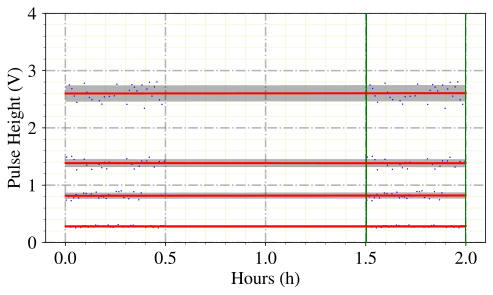

Plot Regression Polynomial at 0.751 hours.
Plot Regression Polynomial at 0.248 hours.


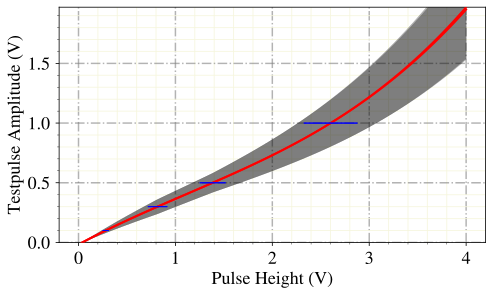

Calculating Recoil Energies: 0.0 %
Energy Calibration for Channel  1
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Intervals seperated by 1 h: [[0.0016666667070239782, 1.503333336552605], [1.503333336552605, 1.998333339691162]]


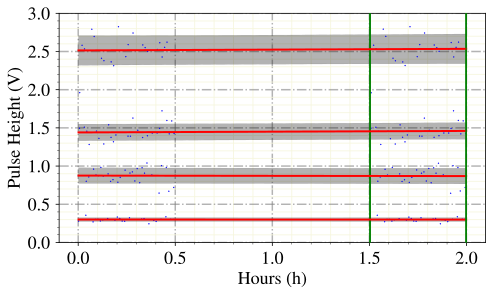

Plot Regression Polynomial at 0.751 hours.
Plot Regression Polynomial at 0.248 hours.


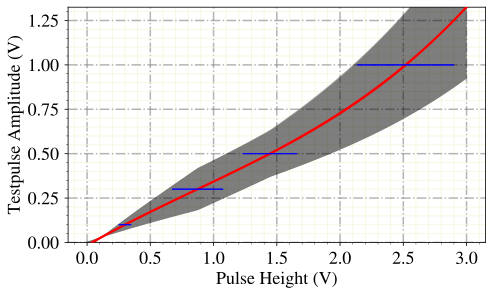

Calculating Recoil Energies: 0.0 %
Finished.


In [17]:
dh.calc_calibration(starts_saturation=[4,3],
                        cpe_factor=cpe_factor,
                        plot=True,
                        only_stable=True,
                        tree=False,
                        linear_with_uncertainty=True,
                        #cut_flag=cut_flag,
                        poly_order=3,
                        )

We see now that there are two new dataset in the events group in the HDF5 file, 'recoil_energy' and 'recoil_energy_sigma'. 

In [18]:
dh.keys('events')

['RFC_predictions', 'add_mainpar', 'controlpuls_stability', 'decay_time_cut', 'event', 'hours', 'labels', 'mainpar', 'of_ph', 'pca_components', 'pca_error', 'pca_projection', 'pred_lstm', 'rate_cut', 'recoil_energy', 'recoil_energy_sigma', 'sev_fit_par_down4', 'sev_fit_rms_down4', 'testpulse_stability', 'time_mus', 'time_s']


So lets plot the spectrum of these two channels. We gonna use the cut on the decay time we did in a prior notebook, to plot the spectrum only for the absorber events.

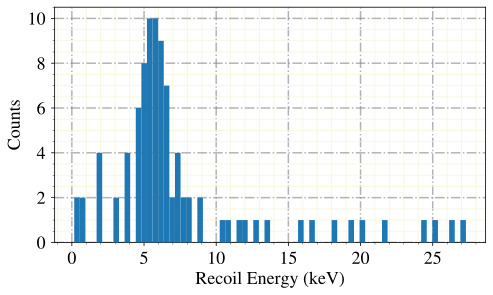

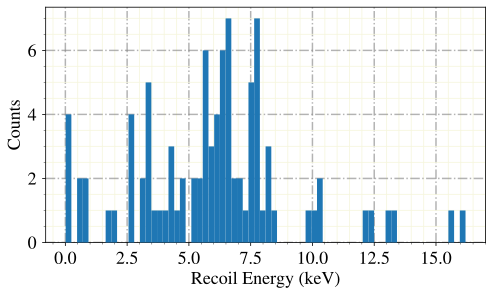

In [6]:
absorbers = dh.get('events', 'decay_time_cut')[0]

for c in channels:
    dh.show_values(group='events', key='recoil_energy', bins=70, idx0=c,
                   xlabel='Recoil Energy (keV)', ylabel='Counts', cut_flag=absorbers)

A more beautiful plot can be done with a kernel density estimation on the histogram. Here we replace every event by a Gaussian with the estimated sigma from the energy calibration.

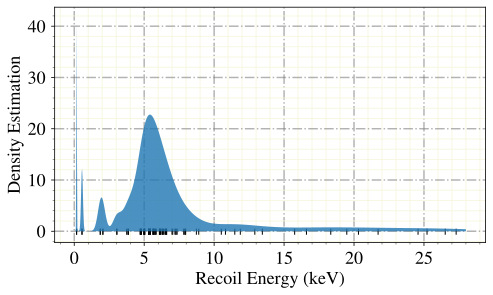

In [7]:
energy_phonon = dh.get('events', 'recoil_energy')[0]
energy_phonon_sigma = dh.get('events', 'recoil_energy_sigma')[0]

x_d = np.linspace(0, 28, 1000)
density = sum(norm(loc=m, scale=s).pdf(x_d) for m,s in zip(energy_phonon[absorbers], 0.3*energy_phonon_sigma[absorbers]))

plt.close()
ai.styles.use_cait_style(dpi=150)
plt.fill_between(x_d, density, alpha=0.8, zorder=25)
plt.plot(energy_phonon[absorbers], np.full_like(energy_phonon[absorbers], -0.1), '|k', markeredgewidth=1)
ai.styles.make_grid()
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Density Estimation')
plt.show()

We can also do a light yield plot.

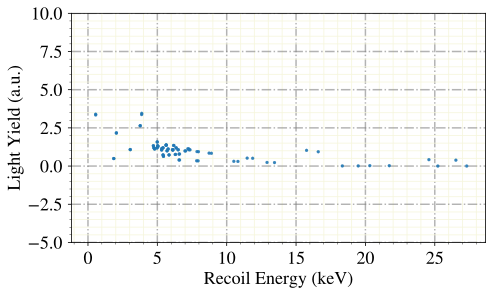

In [8]:
energy_light = dh.get('events', 'recoil_energy')[1]

plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(energy_phonon[absorbers], energy_light[absorbers]/energy_phonon[absorbers], marker='.', alpha=0.9, zorder=10)
ai.styles.make_grid()
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Light Yield (a.u.)')
plt.ylim([-5,10])
plt.show()

We now want to write the energies to an XY file, such that we can do limit calculations in other programs, e.g. in Romeo.

In [9]:
ai.data.write_xy_file(filepath='test_data/spectrum.txt',
                     data=[energy_phonon[absorbers], 
                           energy_light[absorbers]/energy_phonon[absorbers], 
                           energy_phonon_sigma[absorbers]],
                     title='Test Data Spectrum',
                     axis=['Recoil Energy (keV)', 
                           'Light Yield (a.u.)',
                           'Recoil Energy Sigma (keV)'])

Start write.
File written.


Please forward questions and correspondence about this notebook to felix.wagner(at)oeaw.ac.at.